# FWI of the 2D acoustic Marmousi 2 model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion

import sys
sys.path.append("../")
import plotting

MARMOUSI_PATH = '../Marmousi2_elastic.npz'

## Load and plot marmousi 

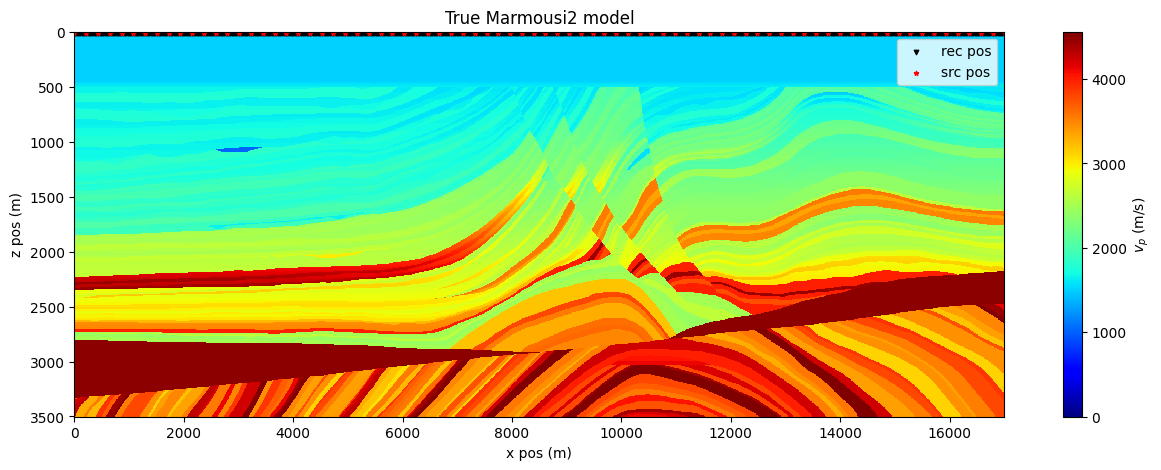

In [4]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 80
x_src = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_src)
z_src = 10.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

plotting.plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation solver

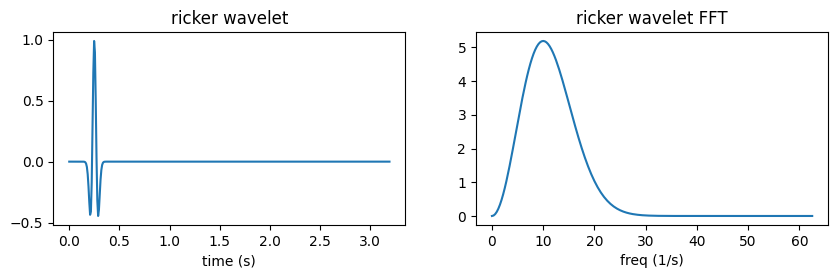

In [3]:
# make a Ricker wavelet
n_t = 626
d_t = 0.008
dom_freq = 10.0
delay = 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plotting.plot_wavelet(ricker[:400],d_t,title='ricker wavelet')

In [4]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(80, 80),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3,4,5,6,7])

## Make observed data

CPU times: user 1min 55s, sys: 52.5 s, total: 2min 47s
Wall time: 17.3 s


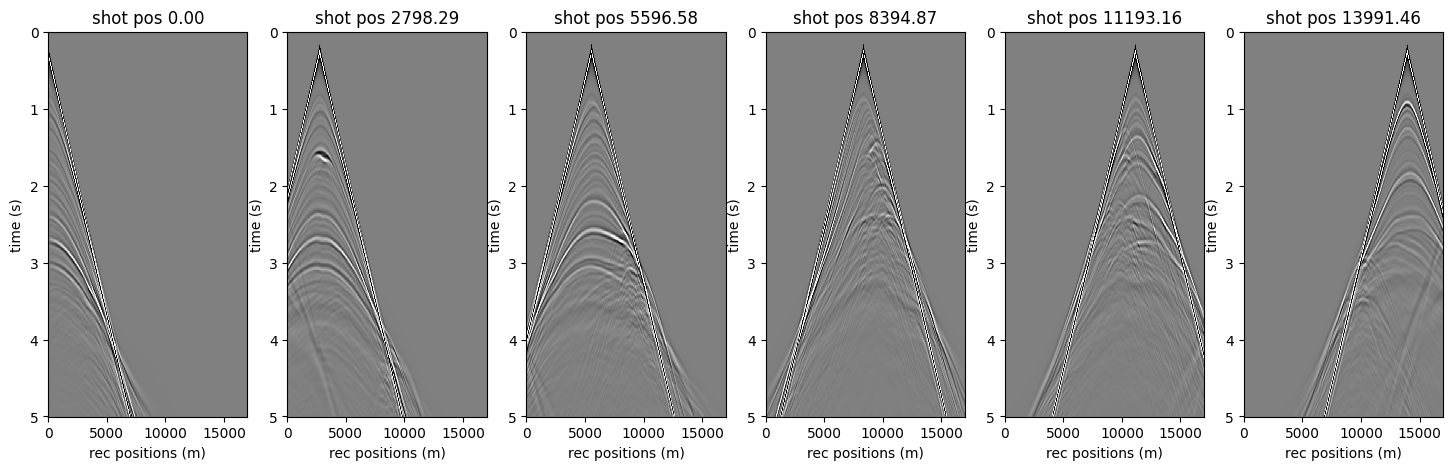

In [5]:
%%time
data_obs = acoustic_2d.forward(true_model)

plotting.plot_data(data_obs,
          d_t,
          src_locations=x_src,
          rec_locations=x_rec)

## Make starting model

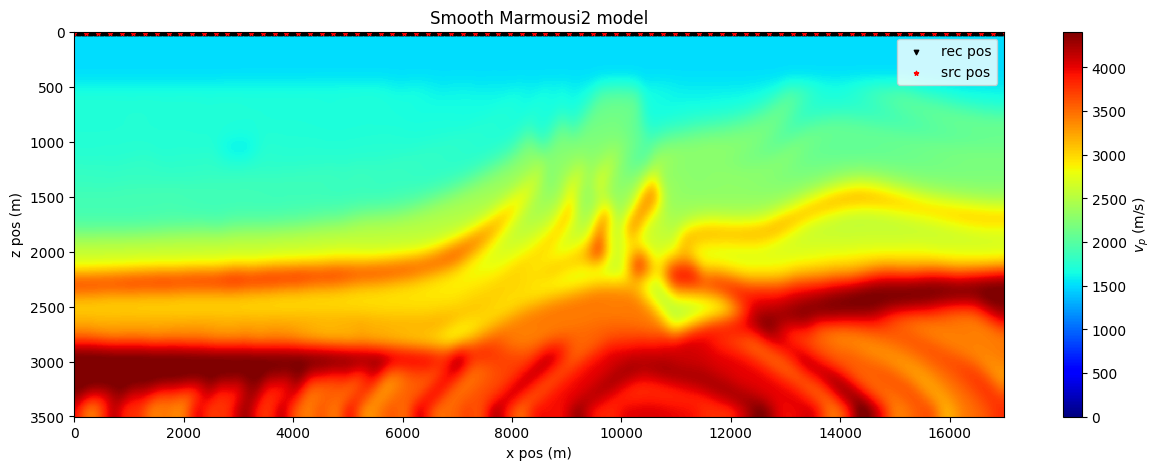

In [6]:
starting_model = ndimage.gaussian_filter(true_model,(20,20))

plotting.plot_model(starting_model,
           title='Smooth Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

In [7]:
# grad_mask = np.ones_like(true_model)
# approx_wb = int(450.0 / model_sampling[1])
# grad_mask[:,:approx_wb] = 0.0
# grad_mask = ndimage.gaussian_filter(grad_mask,(20,20))

# plotting.plot_model(grad_mask,
#            title='FWI gradient mask', 
#            cbar=True,
#            src_locations=srcs,
#            rec_locations=recs,
#             )

## FWI 

In [9]:
fwi_prob = inversion.Fwi(acoustic_2d,
                         data_obs,
                         starting_model,
                         num_iter=500,
                         iterations_per_save=10,
                         solver_type='lbfgs'
                         # gradient_mask=grad_mask,
                        # model_bounds=[1300,5500]
                        )

In [ ]:
%%time

history = fwi_prob.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /net/brick6/scratch2/sfarris/restart_2023-03-22T23-15-21.752854/
##########################################################################################

iter = 000, obj = 7.68102e+04, resnorm = 3.92e+02, gradnorm = 9.11e+00, feval = 1, geval = 1
iter = 001, obj = 3.91653e+04, resnorm = 2.80e+02, gradnorm = 3.64e+00, feval = 4, geval = 2
iter = 002, obj = 3.06329e+04, resnorm = 2.48e+02, gradnorm = 3.12e+00, feval = 7, geval = 3
iter = 003, obj = 2.60284e+04, resnorm = 2.28e+02, gradnorm = 2.50e+00, feval = 10, geval = 4
iter = 004, obj = 2.13381e+04, resnorm = 2.07e+02, gradnorm = 1.84e+00, feval = 13, geval = 5
iter = 005, obj = 1.85815e+04, resnorm = 1.93e+02, gradnorm = 1.29e+00, feval = 16, geval = 6
iter = 006, obj = 1.73527e+04, resnorm = 1.86e+02, gradnorm = 1.05e+00, feval = 19, geval = 7
iter = 007, obj = 1.59629e+04,

In [12]:
history.keys()

dict_keys(['inv_mod', 'gradient', 'model', 'residual', 'obj'])

## Plot objective function as a function of iteration

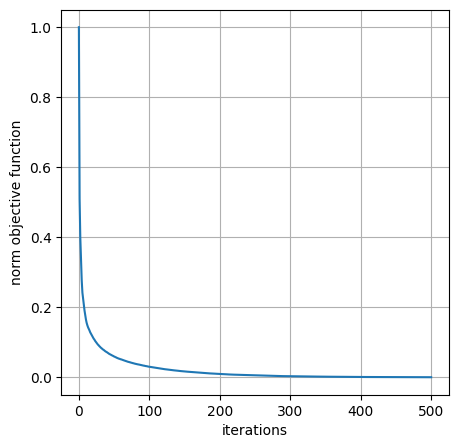

In [14]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
# _ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

In [24]:
loaded_history['gradient'].shape

(51, 3578, 874)

In [ ]:
# plotting.plot_model(loaded_history['model'][-1],
#            title='Final inverted model', 
#            cbar=True,
#                     # vlims=[-0.0025,0.0025]
#                    )

## Plot final model

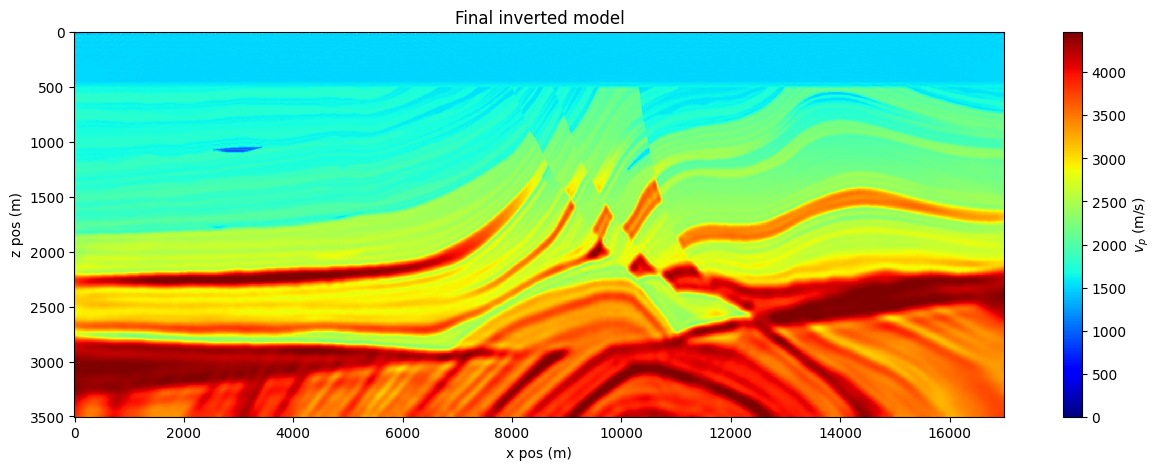

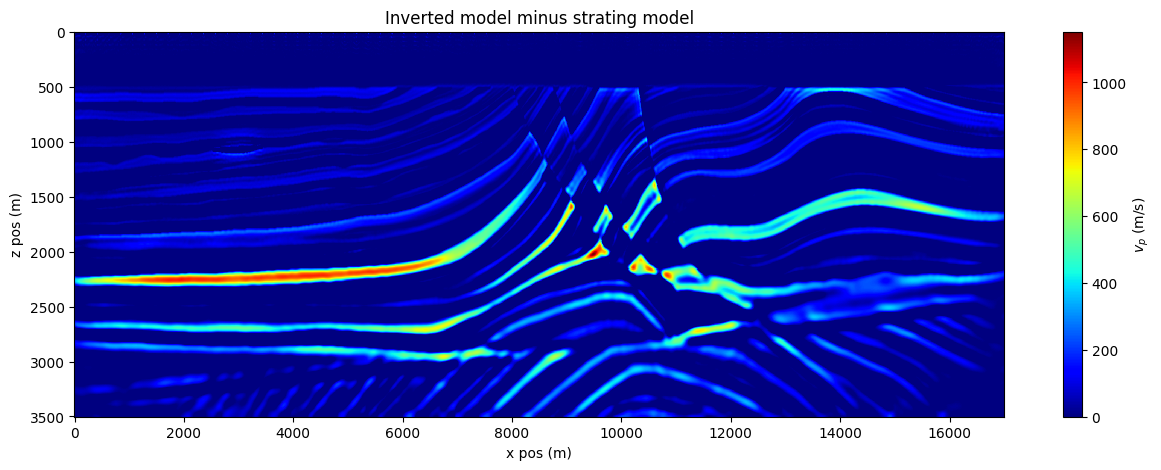

In [15]:
plotting.plot_model(history['inv_mod'],
           title='Final inverted model', 
           cbar=True)

plotting.plot_model(history['inv_mod']-starting_model,
           title='Inverted model minus strating model', 
           cbar=True,
          pclip=100)

## Plot first and last residual

In [16]:
clip = np.percentile(data_obs,99)

plotting.plot_data(history['residual'][0],
          d_t,
          src_locations=x_src,
          rec_locations=x_rec
          clip=clip)

plotting.plot_data(history['residual'][-1],
          d_t,
          src_locations=x_src,
          rec_locations=x_rec
          clip=clip)

SyntaxError: invalid syntax (1920478888.py, line 7)

## Make gif of models over iteration

In [2]:
loaded_history = inversion.load_history(work_dir='wrk',prefix='2023-03-22T231521Z')

In [3]:
loaded_history['model'].shape,loaded_history['obj'][::10].shape

((51, 3578, 874), (51,))

In [16]:
import imageio
import os
import tempfile

obj_skip=10
obj = loaded_history['obj'][::obj_skip]
obj/=obj.max()
iterations = obj_skip*np.arange(len(obj))

x_axis = model_sampling[0] * np.arange(loaded_history['model'].shape[-2])
z_axis = model_sampling[1] * np.arange(loaded_history['model'].shape[-1])

# Create a temporary directory to store the image files
temp_dir = tempfile.mkdtemp()

# Generate the 2D images for each slice along the first axis
image_files = []
for i in range(loaded_history['model'].shape[0]):
    fig ,(ax0,ax1) = plt.subplots(1,2,figsize=(15, 3),gridspec_kw={'width_ratios':[1,3]})
    ax0.plot(iterations,obj)
    ax0.scatter(iterations[i],obj[i])
    ax0.set_title(' ')
    ax0.set_xlabel('iteration #')
    ax0.set_ylabel('fwi loss')
    ax0.set_yscale('log')
    ax0.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
    ax0.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
    
    # z1 = ax1.pcolormesh(x_axis,z_axis,loaded_history['model'][i, :, :].T, cmap='jet', vmin=1500, vmax=4500,shading='nearest')
    # plt.colorbar(z1,cax=ax1)
    ax1.pcolormesh(x_axis/1000.0,z_axis/1000.0,loaded_history['model'][i, :, :].T, cmap='jet', vmin=1500, vmax=4500, shading='nearest')#aspect='auto')
    ax1.set_title(f"iteration {i}")
    ax1.set_xlabel('x pos (km)')
    ax1.set_ylabel('depth (km)')
    ax1.invert_yaxis()

    # Save the image as a temporary file
    image_file = os.path.join(temp_dir, f"slice_{i}.png")
    plt.savefig(image_file)
    plt.close()
    image_files.append(image_file)

# Create the GIF using the image files
gif_filename = "output.gif"
imageio.mimsave(gif_filename, [imageio.imread(f) for f in image_files], fps=10)

# Remove the temporary directory and files
for image_file in image_files:
    os.remove(image_file)
os.rmdir(temp_dir)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
